# Use Soft Q Learning to Play LunarLander-v2

TensorFlow version

In [1]:
%matplotlib inline

import sys
import logging
import itertools

import numpy as np
np.random.seed(0)
import scipy.special
import pandas as pd
import gym
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
tf.random.set_seed(0)
from tensorflow import nn
from tensorflow import losses
from tensorflow import optimizers
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

logging.basicConfig(level=logging.DEBUG,
        format='%(asctime)s [%(levelname)s] %(message)s',
        stream=sys.stdout, datefmt='%H:%M:%S')

In [2]:
env = gym.make('LunarLander-v2')
env.seed(0)
for key in vars(env):
    logging.info('%s: %s', key, vars(env)[key])
for key in vars(env.spec):
    logging.info('%s: %s', key, vars(env.spec)[key])

12:34:09 [INFO] env: <LunarLander<LunarLander-v2>>
12:34:09 [INFO] action_space: Discrete(4)
12:34:09 [INFO] observation_space: Box(-inf, inf, (8,), float32)
12:34:09 [INFO] reward_range: (-inf, inf)
12:34:09 [INFO] metadata: {'render.modes': ['human', 'rgb_array'], 'video.frames_per_second': 50}
12:34:09 [INFO] _max_episode_steps: 1000
12:34:09 [INFO] _elapsed_steps: None
12:34:09 [INFO] id: LunarLander-v2
12:34:09 [INFO] entry_point: gym.envs.box2d:LunarLander
12:34:09 [INFO] reward_threshold: 200
12:34:09 [INFO] nondeterministic: False
12:34:09 [INFO] max_episode_steps: 1000
12:34:09 [INFO] _kwargs: {}
12:34:09 [INFO] _env_name: LunarLander


In [3]:
class DQNReplayer:
    def __init__(self, capacity):
        self.memory = pd.DataFrame(index=range(capacity),
                columns=['state', 'action', 'reward', 'next_state', 'done'])
        self.i = 0
        self.count = 0
        self.capacity = capacity

    def store(self, *args):
        self.memory.loc[self.i] = np.asarray(args, dtype=object)
        self.i = (self.i + 1) % self.capacity
        self.count = min(self.count + 1, self.capacity)

    def sample(self, size):
        indices = np.random.choice(self.count, size=size)
        return (np.stack(self.memory.loc[indices, field]) for field in
                self.memory.columns)

In [4]:
class SQLAgent:
    def __init__(self, env):
        self.action_n = env.action_space.n
        self.gamma = 0.99

        self.replayer = DQNReplayer(10000)

        self.alpha = 0.02

        self.evaluate_net = self.build_net(
                input_size=env.observation_space.shape[0],
                hidden_sizes=[64, 64], output_size=self.action_n)
        self.target_net = models.clone_model(self.evaluate_net)

    def build_net(self, input_size, hidden_sizes, output_size):
        model = keras.Sequential()
        for layer, hidden_size in enumerate(hidden_sizes):
            kwargs = dict(input_shape=(input_size,)) if not layer else {}
            model.add(layers.Dense(units=hidden_size,
                    activation=nn.relu, **kwargs))
        model.add(layers.Dense(units=output_size))
        optimizer = optimizers.Adam(lr=0.001)
        model.compile(loss=losses.mse, optimizer=optimizer)
        return model

    def reset(self, mode=None):
        self.mode = mode
        if self.mode == 'train':
            self.trajectory = []
            self.target_net.set_weights(self.evaluate_net.get_weights())

    def step(self, observation, reward, done):
        qs = self.evaluate_net.predict(observation[np.newaxis])
        q_div_alpha = qs[0] / self.alpha
        v_div_alpha = scipy.special.logsumexp(q_div_alpha)
        prob = np.exp(q_div_alpha - v_div_alpha)
        prob /= prob.sum() # work around for np.random.choice
        action = np.random.choice(self.action_n, p=prob)
        if self.mode == 'train':
            self.trajectory += [observation, reward, done, action]
            if len(self.trajectory) >= 8:
                state, _, _, act, next_state, reward, done, _ = \
                        self.trajectory[-8:]
                self.replayer.store(state, act, reward, next_state, done)
            if self.replayer.count >= 500:
                self.learn()
        return action

    def close(self):
        pass

    def learn(self):
        # replay
        states, actions, rewards, next_states, dones = self.replayer.sample(128)

        # train
        next_qs = self.target_net.predict(next_states)
        next_vs = self.alpha * scipy.special.logsumexp(next_qs / self.alpha,
                axis=-1)
        us = rewards + self.gamma * (1. - dones) * next_vs
        targets = self.evaluate_net.predict(states)
        targets[np.arange(us.shape[0]), actions] = us
        self.evaluate_net.fit(states, targets, verbose=0)


agent = SQLAgent(env)

12:34:10 [INFO] ==== train ====
12:34:17 [DEBUG] train episode 0: reward = -445.54, steps = 136
12:34:20 [DEBUG] train episode 1: reward = -153.23, steps = 72
12:34:26 [DEBUG] train episode 2: reward = -117.16, steps = 99
12:34:31 [DEBUG] train episode 3: reward = -518.03, steps = 95
12:34:36 [DEBUG] train episode 4: reward = -671.37, steps = 88
12:34:52 [DEBUG] train episode 5: reward = -89.08, steps = 81
12:35:17 [DEBUG] train episode 6: reward = -213.88, steps = 124
12:35:54 [DEBUG] train episode 7: reward = -343.83, steps = 182
12:36:52 [DEBUG] train episode 8: reward = -117.37, steps = 301
12:37:20 [DEBUG] train episode 9: reward = -232.42, steps = 145
12:38:08 [DEBUG] train episode 10: reward = -56.57, steps = 251
12:38:59 [DEBUG] train episode 11: reward = -19.96, steps = 267
12:39:50 [DEBUG] train episode 12: reward = -25.62, steps = 274
12:40:24 [DEBUG] train episode 13: reward = -35.56, steps = 174
12:41:27 [DEBUG] train episode 14: reward = -100.93, steps = 331
12:42:15 [DEB

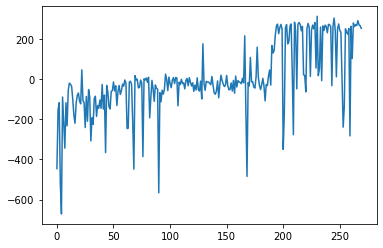

In [5]:
def play_episode(env, agent, max_episode_steps=None, mode=None, render=False):
    observation, reward, done = env.reset(), 0., False
    agent.reset(mode=mode)
    episode_reward, elapsed_steps = 0., 0
    while True:
        action = agent.step(observation, reward, done)
        if render:
            env.render()
        if done:
            break
        observation, reward, done, _ = env.step(action)
        episode_reward += reward
        elapsed_steps += 1
        if max_episode_steps and elapsed_steps >= max_episode_steps:
            break
    agent.close()
    return episode_reward, elapsed_steps


logging.info('==== train ====')
episode_rewards = []
for episode in itertools.count():
    episode_reward, elapsed_steps = play_episode(env.unwrapped, agent,
            max_episode_steps=env._max_episode_steps, mode='train')
    episode_rewards.append(episode_reward)
    logging.debug('train episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
    if np.mean(episode_rewards[-10:]) > 250:
        break
plt.plot(episode_rewards)


logging.info('==== test ====')
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.debug('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))

In [6]:
env.close()